# gridfinder
Full source code here: https://github.com/carderne/gridfinder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
import seaborn as sns
from IPython.display import display, Markdown

import numpy as np
import rasterio
import geopandas as gpd

from gridfinder._util import save_raster, clip_line_poly
from gridfinder.prepare import clip_rasters, merge_rasters, create_filter, prepare_ntl, prepare_roads
from gridfinder.gridfinder import get_targets_costs, optimise
from gridfinder.post import threshold, accuracy, guess2geom

## Enter country name and input parameters
Valid country names listed in countries.csv

In [3]:
country_name = 'Rwanda'

In [4]:
ntl_percentile = 70
ntl_upsample = 2
ntl_threshold = 2.1
guess_cutoff = 0.5

In [5]:
ntl_folder_in = Path('NTL')
roads_in = Path('roads') / f'{country_name.lower()}.gpkg'

aoi_in = 'gadm.gpkg'
aoi = gpd.read_file(aoi_in)
aoi = aoi.loc[aoi['NAME_0'] == country_name]

folder_out = Path(country_name)
if not os.path.exists(folder_out):
    os.makedirs(folder_out)

ntl_folder_out = folder_out / 'NTL_clipped'
ntl_merged_out = folder_out / 'ntl_merged.tif'
ntl_thresh_out = folder_out / 'ntl_thresh.tif'
roads_out = folder_out / 'roads.tif'
dist_out = folder_out / 'dist.tif'
guess_out = folder_out / 'guess.tif'
final_out = folder_out / 'guess.gpkg'

Doing VIIRS_2016_03.tif
Doing VIIRS_2016_08.tif
Doing VIIRS_2016_05.tif
Doing VIIRS_2016_09.tif
Doing VIIRS_2016_06.tif
Doing VIIRS_2016_02.tif
Doing VIIRS_2016_01.tif
Doing VIIRS_2016_11.tif
Doing VIIRS_2016_07.tif
Doing VIIRS_2016_12.tif
Doing VIIRS_2016_04.tif
Doing VIIRS_2016_10.tif


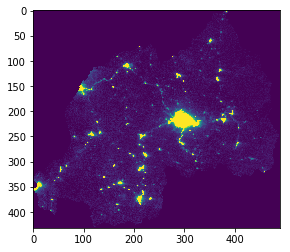

In [6]:
clip_rasters(ntl_folder_in, ntl_folder_out, aoi)
raster_merged, affine = merge_rasters(ntl_folder_out, percentile=ntl_percentile)
save_raster(ntl_merged_out, raster_merged, affine)
plt.imshow(raster_merged, vmin=0, vmax=1)

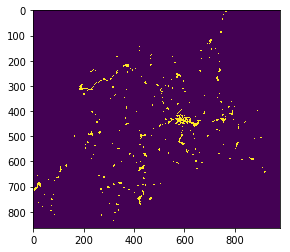

In [6]:
ntl_filter = create_filter()
ntl, ntl_filtered, ntl_interp, ntl_thresh, affine = prepare_ntl(ntl_merged_out, aoi, ntl_filter=ntl_filter,
                                                                threshold=ntl_threshold, upsample_by=ntl_upsample)
save_raster(ntl_thresh_out, ntl_thresh, affine)
plt.imshow(ntl_thresh, cmap='viridis')

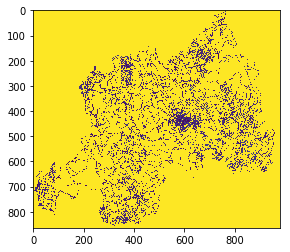

In [7]:
roads, roads_clipped, aoi, roads_raster, affine = prepare_roads(
    roads_in, aoi, ntl_thresh.shape, affine)
save_raster(roads_out, roads_raster, affine)
plt.imshow(roads_raster, cmap='viridis')

'98.00 %'

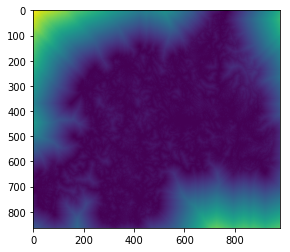

In [9]:
targets, costs, start = get_targets_costs(ntl_thresh_out, roads_out)
dist = optimise(targets, costs, start, display_progress=True)
save_raster(dist_out, dist, affine)
plt.imshow(dist)

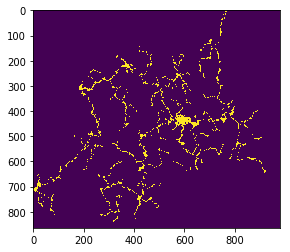

In [11]:
dists_r, guess, transform = threshold(dist_out, cutoff=0.5)
save_raster(guess_out, guess, transform)
plt.imshow(guess, cmap='viridis')

/home/ubuntu/.local/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


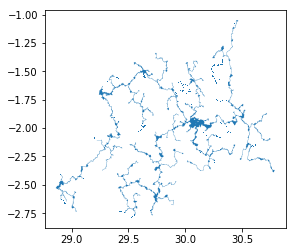

In [6]:
guess_r, guess_geojson, guess_gdf = guess2geom(guess_out)
guess_gdf.to_file(final_out, driver='GPKG')
guess_gdf.plot()

In [13]:
import shutil
zip_file = Path(f'Downloads/{country_name}')
shutil.make_archive(zip_file, 'zip', folder_out)
display(Markdown(f'<a href="{zip_file}.zip" target="_blank">Download results as zip file</a>'))

<a href="Downloads/Rwanda.zip" target="_blank">Download results as zip file</a>